# Crime Analysis in Washington D.C.

#### Xueyan Zhang 11811736

Crime is a common behavior in today's human society, which is inextricably linked to the economy, culture, politics, technology and people's happiness index. In order to maintain social order and reduce the crime rate, the connection between crime and human society should be investigated in depth.

## 1. Data resource
The crime data in this case is based on the data in https://dcatlas.dcgis.dc.gov/crimecards/. The crime data contains 449,203 cases from 2008 to January 2021. Each case contains 29 variables, including detailed information such as the location, time, nature, and means of the case, as well as some information about the crime area, such as latitude and longitude, block, PSA, etc.

In [1]:
import pandas as pd
from pandas import Series
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection
from scipy.spatial import distance
import re
import time
import datetime
import folium

## 2. Data exploration and preprocessing

In [2]:
cr = pd.read_csv('DC_Crime.csv')
print(cr.shape)
cr.head(5)

(449203, 29)


,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,...,BLOCK,START_DATE,CCN,OFFENSE,OCTO_RECORD_ID,ANC,REPORT_DAT,METHOD,location,LATITUDE
0,cluster 21,8702.0,property,-77.003574,2017-04-29T08:00:23.000,theft f/auto,day,138139.0,5.0,5.0,...,150 - 299 block of q street ne,2017-04-29T01:30:14.000,17070672,theft f/auto,17070672-01,5E,2017-04-29T13:49:31.000Z,others,"38.911121322949178,-77.003576581965632",38.911114
1,cluster 16,1600.0,property,-77.026557,2017-04-29T08:30:37.000,theft f/auto,day,146051.0,4.0,4.0,...,7600 - 7699 block of georgia avenue nw,2017-04-29T02:30:10.000,17070675,theft f/auto,17070675-01,4A,2017-04-29T14:38:59.000Z,others,"38.982391883146363,-77.026559339798794",38.982384
2,cluster 8,4702.0,property,-77.020913,2017-04-29T11:10:57.000,theft/other,day,137185.0,1.0,6.0,...,600 - 699 block of k street nw,2017-04-29T10:43:33.000,17070714,theft/other,17070714-01,6E,2017-04-29T15:19:02.000Z,others,"38.902525540064957,-77.020915170313728",38.902518
3,cluster 31,7808.0,property,-76.919601,2017-04-28T09:30:33.000,theft/other,day,135903.0,6.0,7.0,...,5715 5739 block of blaine street ne,2017-04-28T09:15:27.000,17070736,theft/other,17070736-01,7C,2017-04-29T16:11:44.000Z,others,"38.890951021927407,-76.919603310082607",38.890943
4,cluster 39,10900.0,property,-77.003927,2017-04-29T13:42:11.000,theft/other,day,128340.0,7.0,8.0,...,4610 - 4659 block of south capitol street,2017-04-29T13:03:40.000,17070780,theft/other,17070780-01,8D,2017-04-29T18:17:15.000Z,others,"38.822847890448664,-77.003929146312586",38.822840


Among the variables, "CCN" is the case number, which cannot provide useful information for actual model construction, so it is deleted. There are three columns describing longitude and latitude data, namely LATITUDE, LONGITUDE and location. Location is deleted here because location can be described by the other two sets of data.

Similarly, the information in offensekey includes "OFFENSE", "offense-text" and "offensegroup". Considering the subsequent analysis, "offense-text" is deleted here.

In [3]:
del cr["CCN"]
del cr["location"]
del cr["offense-text"]

In [4]:
clu = list()
for i in range (len(cr)):
    temp = str(cr.loc[i,"NEIGHBORHOOD_CLUSTER"])
    if temp[0] == "c":
        a = re.findall(r'\d+',temp)
        b = int(''.join(a))
        clu.append(b)
    else:
        clu.append(0)

cr["NEIGHBORHOOD_CLUSTER"] = clu

In [5]:
v_p = list()
for i in range (len(cr)):
    temp = str(cr.loc[i,"VOTING_PRECINCT"])
    if temp[0] == "p":
        a = re.findall(r'\d+',temp)
        b = int(''.join(a))
        v_p.append(b)
    else:
        v_p.append(0)
        
cr["VOTING_PRECINCT"] = v_p
cr.head()

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,SHIFT,YBLOCK,DISTRICT,WARD,YEAR,...,VOTING_PRECINCT,XBLOCK,BLOCK,START_DATE,OFFENSE,OCTO_RECORD_ID,ANC,REPORT_DAT,METHOD,LATITUDE
0,21,8702.0,property,-77.003574,2017-04-29T08:00:23.000,day,138139.0,5.0,5.0,2017,...,75,399690.0,150 - 299 block of q street ne,2017-04-29T01:30:14.000,theft f/auto,17070672-01,5E,2017-04-29T13:49:31.000Z,others,38.911114
1,16,1600.0,property,-77.026557,2017-04-29T08:30:37.000,day,146051.0,4.0,4.0,2017,...,62,397699.0,7600 - 7699 block of georgia avenue nw,2017-04-29T02:30:10.000,theft f/auto,17070675-01,4A,2017-04-29T14:38:59.000Z,others,38.982384
2,8,4702.0,property,-77.020913,2017-04-29T11:10:57.000,day,137185.0,1.0,6.0,2017,...,18,398186.0,600 - 699 block of k street nw,2017-04-29T10:43:33.000,theft/other,17070714-01,6E,2017-04-29T15:19:02.000Z,others,38.902518
3,31,7808.0,property,-76.919601,2017-04-28T09:30:33.000,day,135903.0,6.0,7.0,2017,...,96,406975.0,5715 5739 block of blaine street ne,2017-04-28T09:15:27.000,theft/other,17070736-01,7C,2017-04-29T16:11:44.000Z,others,38.890943
4,39,10900.0,property,-77.003927,2017-04-29T13:42:11.000,day,128340.0,7.0,8.0,2017,...,125,399659.0,4610 - 4659 block of south capitol street,2017-04-29T13:03:40.000,theft/other,17070780-01,8D,2017-04-29T18:17:15.000Z,others,38.822840


### 2.1 Types and methods of crime

In variable "offensekey", cases are divided into nine specific types. For this type of variable with multiple types, you can use a bar chart to visually observe its number. In order to facilitate subsequent research, it is better to encode it as an integer. Among them, 0 to 4 belong to "property" and 5 to 8 belong to "violent".

In [6]:
print(cr["METHOD"].value_counts())
met_id = [0,1,2]
metkey = ["others","gun","knife"]
met_d = {key:value for key, value in zip(metkey,met_id)}
cr["METHOD"] = cr["METHOD"].map(met_d)

others    408728
gun        26957
knife      13518
Name: METHOD, dtype: int64


In [7]:
print((cr["OFFENSE"]).value_counts())

theft/other                   175631
theft f/auto                  119119
robbery                        42215
motor vehicle theft            42159
burglary                       35898
assault w/dangerous weapon     28893
sex abuse                       3115
homicide                        1817
arson                            356
Name: OFFENSE, dtype: int64


It is easy to see that the contents recorded in “OFFENSE” and “offensegroup” are completely repeated.

property    373163
violent      76040
Name: offensegroup, dtype: int64
property    0.830722
violent     0.169278
Name: offensegroup, dtype: float64
------------------------------------------------
property|theft/other                  175631
property|theft f/auto                 119119
violent|robbery                        42215
property|motor vehicle theft           42159
property|burglary                      35898
violent|assault w/dangerous weapon     28893
violent|sex abuse                       3115
violent|homicide                        1817
property|arson                           356
Name: offensekey, dtype: int64


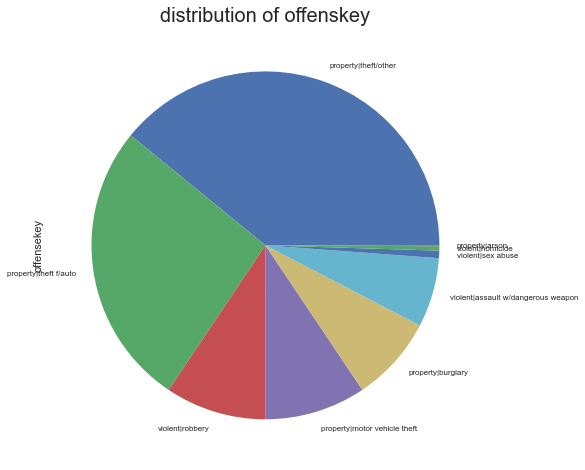

In [8]:
print(cr.offensegroup.value_counts())
print(cr.offensegroup.value_counts()/len(cr))
print("------------------------------------------------")
print(cr.offensekey.value_counts())
# del cr["offensegroup"]
gp_id = [0,1]
gpkey = ["property","violent"]
gp_d = {key:value for key, value in zip(gpkey,gp_id)}
cr["offensegroup"] = cr["offensegroup"].map(gp_d)
del cr["OFFENSE"]

plt.style.use('seaborn')
cr['offensekey'].value_counts().plot.pie(figsize = (15, 8), textprops = {'fontsize':8})

plt.title('distribution of offenskey',fontsize = 20)

plt.yticks(rotation = 90)
plt.show()

of_id = [0,1,2,3,4,5,6,7,8]
ofkey = ["property|theft/other",
    "property|theft f/auto",
    "property|motor vehicle theft",
    "property|burglary",
    "property|arson",
    "violent|robbery",
    "violent|assault w/dangerous weapon",
    "violent|sex abuse",
    "violent|homicide"]
of_d = {key:value for key, value in zip(ofkey, of_id)}
cr["offensekey"] = cr["offensekey"].map(of_d)

It can be seen that among the 449,203 samples, there were 373,163 cases of property crimes and 76,040 cases of violent crimes, accounting for 83.07% and 16.93% respectively. Property crimes accounted for the vast majority.

At the same time, it can be seen from the data and charts that the number of property crimes is far greater than that of violent crimes, among which theft is far greater than other types of crimes.

### 2.2 Time of crime occurance

There are mainly two dimensions for the time when a crime occurs: one is the year, and the other is the shift. The data covers the period from 2008 to January 2021, and the shifts are divided into three categories: daytime, nighttime, and midnight.

First, we look at the data for each shift and code it numerically. Daytime is coded as 0, night as 1, and midnight as 2.

In [9]:
print(cr.SHIFT.value_counts())
print("------------------------------------------------")
print(cr.SHIFT.value_counts()/len(cr))

SHIFT_dict = {"day":0,"evening":1,"midnight":2}
cr["SHIFT"] = cr["SHIFT"].map(SHIFT_dict)

evening     191978
day         169650
midnight     87575
Name: SHIFT, dtype: int64
------------------------------------------------
evening     0.427375
day         0.377669
midnight    0.194956
Name: SHIFT, dtype: float64


Among all the cases, 169,650 occurred during the day, accounting for 37.77%; 191,978 occurred at night, accounting for 42.74%; and 87,575 occurred at midnight, accounting for 19.50%.

In [10]:
# print(cr_time)

Next, classify the cases in different time periods based on the year and draw a bar chart for easy observation.

    year midnight  night    day
0   2008     7039  14237  13033
1   2009     6249  13045  12021
2   2010     5959  13607  12111
3   2011     6211  14144  12938
4   2012     6250  14491  14577
5   2013     6527  15049  14320
6   2014     6758  16173  15509
7   2015     7018  16263  14047
8   2016     7502  16689  13037
9   2017     6899  14015  12199
10  2018     7234  14383  12143
11  2019     7535  14924  11450
12  2020     5503  12293  10075
13  2021      891   2665   2190


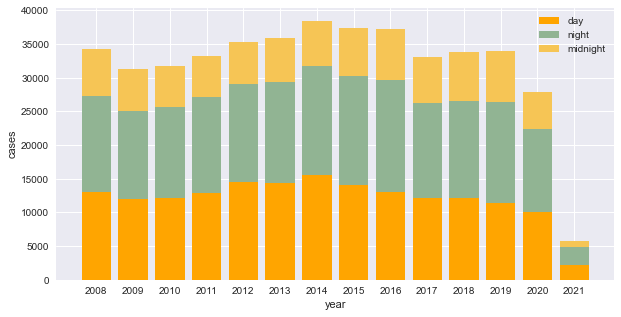

In [11]:
cr_time = cr[["YEAR","SHIFT"]]
time_day = cr_time[cr_time["SHIFT"] == 0].YEAR.value_counts()
time_night = cr_time[cr_time["SHIFT"] == 1].YEAR.value_counts()
time_mid = cr_time[cr_time["SHIFT"] == 2].YEAR.value_counts()

sh = pd.DataFrame(columns = ('year','midnight','night','day'))
for num in range (2008, 2022):
    sh = sh.append({'year':num,'midnight':time_mid[num],'night':time_night[num],'day':time_day[num]},ignore_index = True)
print(sh)

plt.figure(figsize = (10,5))
plt.style.use('seaborn')

plt.bar(sh.year,sh.day, align="center", color="orange",tick_label = sh.year, label="day")
plt.bar(sh.year,sh.night, align="center", bottom=sh.day, color="#91B493", label="night")
for i in range(0, len(sh)):
    sh.night[i] = sh.night[i] + sh.day[i]
plt.bar(sh.year,sh.midnight, align="center", bottom=sh.night, color="#F6C555", label="midnight")

plt.xlabel("year")
plt.ylabel("cases")
plt.legend()
plt.show()

It can be seen intuitively from the graph that in each year, the most cases occurred at night, followed by midnight, and the least during the day; in recent years (from 2014 to the present), excluding the impact of 2021 due to the statistics of only a small amount of data, the total number of cases has shown a downward trend, but the overall change is not significant.

Next, let’s analyze the impact of each day of the week on the number of crimes.

In [12]:
dayOfWeek_abbr = list()
dayOfWeek_num = list()

def switch(x):
    return{"0":"Mon.",
            "1":"Tue.",
            "2":"Wed.",
            "3":"Thur.",
            "4":"Fri.",
            "5":"Sat.",
            "6":"Sun."}.get(x)

for i in range (len(cr)):
    if(str(cr.loc[i,"START_DATE"])[0]).isdigit():
        y = int(cr.loc[i,"START_DATE"][0:4])
        m = int(cr.loc[i,"START_DATE"][5:7])
        d = int(cr.loc[i,"START_DATE"][8:10])
        date_num = datetime.datetime(y,m,d).strftime("%w")
        date = switch(date_num)
        dayOfWeek_abbr.append(date)
        dayOfWeek_num.append(int(date_num))
    else:
        dayOfWeek_num.append(-1)

In [13]:
abbr = ["Mon.","Tue.","Wed.","Thur.","Fri.","Sat.","Sun."]
days = pd.Series(index = abbr)

for index in days.index:
    days[index] = dayOfWeek_abbr.count(index)
    
print(days)

Mon.     61199.0
Tue.     63841.0
Wed.     62551.0
Thur.    62437.0
Fri.     61988.0
Sat.     69742.0
Sun.     67431.0
dtype: float64


<ipython-input-13-a26fe54023eb>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  days = pd.Series(index = abbr)


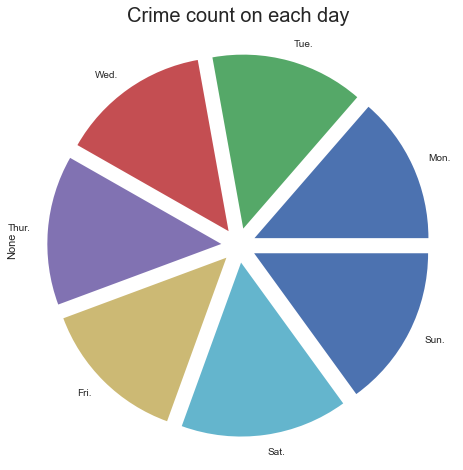

In [14]:
plt.style.use('seaborn')

days.plot.pie(figsize = (15, 8), explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))

plt.title('Crime count on each day',fontsize = 20)

plt.xticks(rotation = 90)
plt.show()

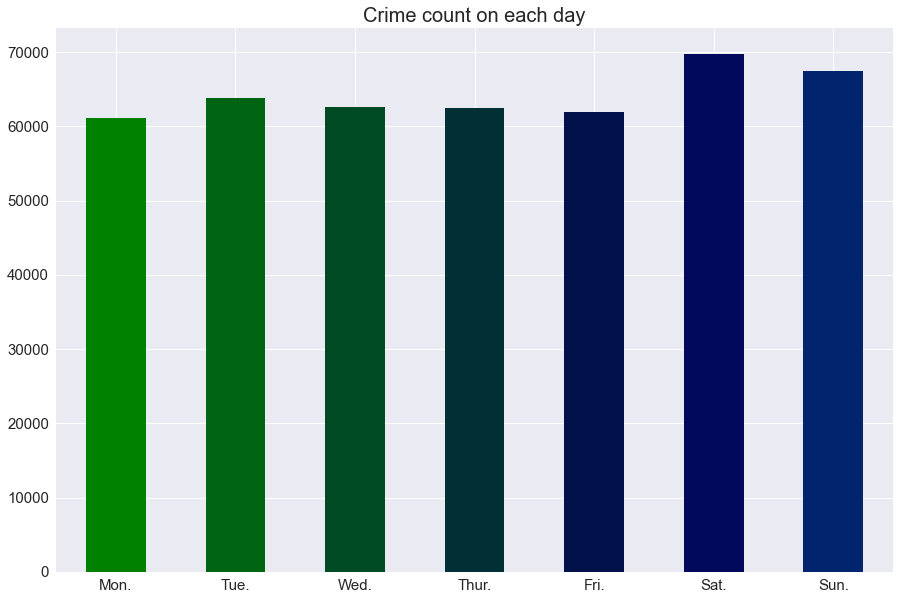

In [15]:
plt.style.use('seaborn')

color = plt.cm.ocean(np.linspace(0, 1, 15))
days.plot.bar(color = color, figsize = (15, 10))

plt.title('Crime count on each day',fontsize = 20)

plt.yticks(fontsize = 15)
plt.xticks(rotation = 0,fontsize = 15)
plt.show()

In [16]:
cr["DAY_OF_WEEK"] = ''
# day_id = [0,1,2,3,4,5,6,7,8]
# day_d = {key:value for key, value in zip(abbr, day_id)}
cr["DAY_OF_WEEK"] = dayOfWeek_num

Overall, there are more crimes on weekends than on weekdays, but the impact is not significant.

Analyze the impact of the season on the number of crimes. 

In [17]:
cr["SEASON"] = ''
season = list()

# 0:spring, 1:summer, 2:autumn, 3:winter
for i in range (len(cr)):
    temp = str(cr.loc[i,"END_DATE"])
    if temp[0] == '2':
        month = int(''.join(temp[5:7]))
        if month <=2 or month == 12 :
            ss = 3
        elif month <= 5:
            ss = 0
        elif month <= 8:
            ss = 1
        else:
            ss = 2
    else:
        ss = -1    
    season.append(ss)
        
cr["SEASON"] = season
cr["SEASON"].value_counts()

 1    113175
 2    111037
 0     99331
 3     98851
-1     26809
Name: SEASON, dtype: int64

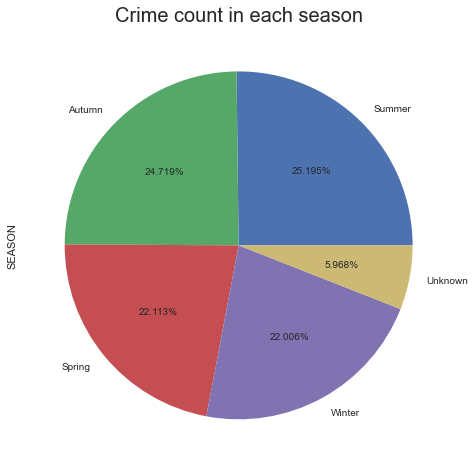

In [18]:
plt.style.use('seaborn')

labels = ['Summer','Autumn','Spring','Winter','Unknown']
cr["SEASON"].value_counts().plot.pie(labels = labels, figsize = (15, 8),autopct = '%.3f%%')
plt.title('Crime count in each season',fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

Crime rates are higher in the summer and fall than in the spring and winter, but overall, the impact is small.

Analyze the effect of time of day on crime occurrence.

In [19]:
cr["TIME"] = ''
time = list()

for i in range (len(cr)):
    temp = str(cr.loc[i,"START_DATE"])
    if temp[0] == '2':
        hr = int(''.join(temp[11:13]))
    else:
        hr = -1
    time.append(hr)
    
cr["TIME"] = time

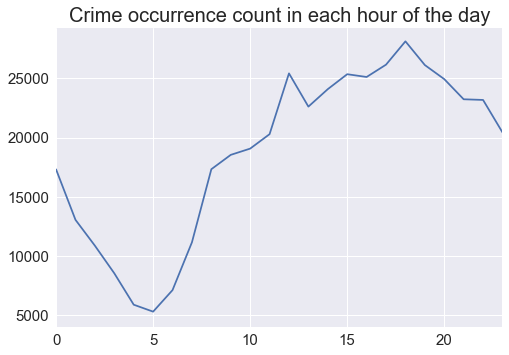

In [20]:
plt.style.use('seaborn')

# color = plt.cm.ocean(np.linspace(0, 1, 15))
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
y = [cr["TIME"].value_counts()[label] for label in x]
plt.plot(x,y)

plt.title('Crime occurrence count in each hour of the day',fontsize = 20)

plt.yticks(fontsize = 15)
plt.xticks(rotation = 0,fontsize = 15)
plt.xlim(0,23)
plt.ylim(4000)
plt.show()

# 3. Correlation between different features

Calculate the duration (" END_DATE " - " START_DATE ", in hours) of each recorded case.

In [21]:
cr["DURATION"] = ''
duration = list()

# 1:end date, 2:start date
def dateDiffInHours(t1, t2):
    td = t1 - t2
    return td.days * 24 + td.seconds/3600 + 1
        
for i in range (len(cr)):
    start = str(cr.loc[i,"START_DATE"])
    end = str(cr.loc[i,"END_DATE"])
    if start[0] == '2' and end[0] == '2':
        y1 = int(''.join(end[0:4]))
        y2 = int(''.join(start[0:4]))
        m1 = int(''.join(end[5:7]))
        m2 = int(''.join(start[5:7]))
        d1 = int(''.join(end[8:10])) 
        d2 = int(''.join(start[8:10]))
        h1 = int(''.join(end[11:13]))
        h2 = int(''.join(start[11:13]))
        mm1 = int(''.join(end[14:16]))
        mm2 = int(''.join(start[14:16]))
        endTime = datetime.datetime(y1,m1,d1,h1,mm1)
        startTime = datetime.datetime(y2,m2,d2,h2,mm2)
        dure = abs(dateDiffInHours(endTime,startTime))
    else:
        dure = -1
    duration.append(dure)
    

cr["DURATION"] = duration
cr.DURATION.value_counts()
# max(cr["DURATION"])
# plt.scatter(cr["DURATION"], cr["offensekey"])
# plt.xlim(0,10000)
# plt.show()

-1.000000       26829
 1.000000       22781
 1.083333       22557
 1.166667       14949
 1.016667       13820
                ...  
 58.050000          1
 58.450000          1
 164.216667         1
 164.783333         1
 3061.000000        1
Name: DURATION, Length: 12248, dtype: int64

Draw a heat map based on all the data that can be represented by numerical values and are not repeated:

E:\annaconda\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


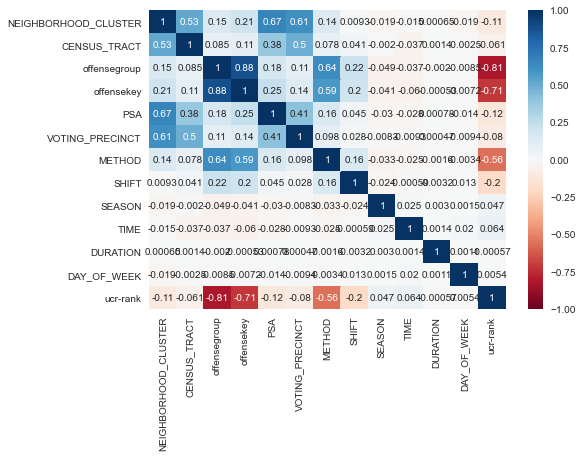

In [22]:
cr1 = cr[["NEIGHBORHOOD_CLUSTER","CENSUS_TRACT","offensegroup",
          "offensekey","PSA","VOTING_PRECINCT","METHOD","SHIFT",
          "SEASON","TIME","DURATION","DAY_OF_WEEK","ucr-rank"]]
cr1.fillna(value = -1,inplace = True)
cr1.isnull().sum()
np.float64(cr1)
sns.set_context(font_scale=1.5)
cr1=cr1.dropna(how='any',axis=0)
sns.heatmap(cr1.corr(),vmin=-1,vmax=1,annot = True,cmap=sns.color_palette('RdBu',n_colors=128))
plt.show()

In addition to the characteristics of the region and ucr-rank, which is used to indicate the degree of crime danger (obviously, the smaller the ucr-rank value, the more dangerous it is, and violent in offensegroup and knife and gun in METHOD will obviously have higher ucr-rank), there are few other relevant features. The following selects several for analysis.

## 3.1 Correlation between "SHIFT" and "offensekey"

In [23]:
cr_shift_offensekey = cr[["SHIFT","offensekey"]]
cr_shift_offensekey.corr()

,SHIFT,offensekey
SHIFT,1.000000,0.204117
offensekey,0.204117,1.000000


The correlation coefficient between the two is about 0.2. Not particularly correlated, but not completely unrelated either. 

In [24]:
offense_day = cr_shift_offensekey[cr_shift_offensekey["SHIFT"] == 0].offensekey.value_counts()
offense_night = cr_shift_offensekey[cr_shift_offensekey["SHIFT"] == 1].offensekey.value_counts()
offense_mid = cr_shift_offensekey[cr_shift_offensekey["SHIFT"] == 2].offensekey.value_counts()
offense_lists = [offense_day,offense_night,offense_mid]

for alist in offense_lists:
    for i in (0,8):
        if i not in alist.index:
            alist[i] = 0

shift_offensekey = pd.DataFrame(columns = ('offensekey','midnight','night','day'))
for num in range (0,9):
    shift_offensekey = shift_offensekey.append({
        'offensekey':num,
        'midnight':(offense_mid[num]/cr["offensekey"].value_counts()[num]),
        'night':(offense_night[num]/cr["offensekey"].value_counts()[num]),
        'day':(offense_day[num]/cr["offensekey"].value_counts()[num])},
        ignore_index = True)
print(shift_offensekey)

   offensekey  midnight     night       day
0         0.0  0.131184  0.493432  0.375384
1         1.0  0.170728  0.364316  0.464955
2         2.0  0.190541  0.365379  0.444081
3         3.0  0.191571  0.432030  0.376400
4         4.0  0.353933  0.337079  0.308989
5         5.0  0.363425  0.424257  0.212318
6         6.0  0.378569  0.408888  0.212543
7         7.0  0.341894  0.373034  0.285072
8         8.0  1.000000  0.000000  0.000000


Text(0, 0.5, 'Offensekey Percentage')

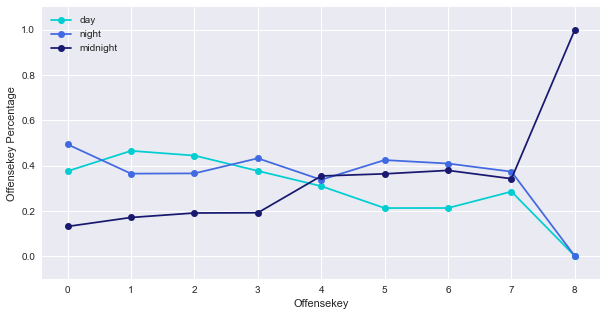

In [25]:
x = range(0,9)
y1 = shift_offensekey["day"]
y2 = shift_offensekey["night"]
y3 = shift_offensekey["midnight"]

plt.figure(figsize = (10,5))
plt.style.use('seaborn')

plt.plot(x,y1,marker = 'o',color = "darkturquoise",label = 'day')
plt.plot(x,y2,marker = 'o',color = "royalblue",label = "night")
plt.plot(x,y3,marker = 'o',color = "midnightblue",label = "midnight")

plt.legend(labels = ["day","night","midnight"],loc = "upper left")

plt.ylim(-0.1,1.1)
plt.xlabel("Offensekey")
plt.ylabel("Offensekey Percentage")

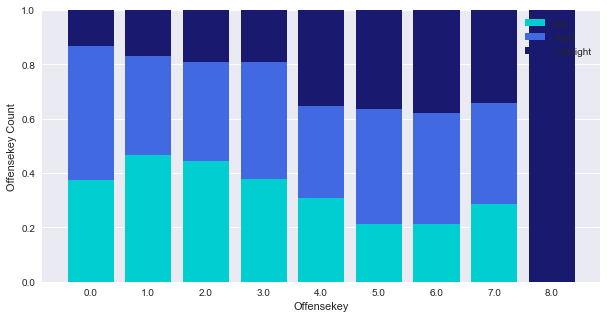

In [26]:
plt.figure(figsize = (10,5))
plt.style.use('seaborn')

plt.bar(shift_offensekey.offensekey,shift_offensekey.day, align="center", 
        color="darkturquoise",tick_label = shift_offensekey.offensekey, label="day")
plt.bar(shift_offensekey.offensekey,shift_offensekey.night, align="center", 
        bottom=shift_offensekey.day, color="royalblue", label="night")
for i in range(0, 9):
    shift_offensekey.night[i] = shift_offensekey.night[i] + shift_offensekey.day[i]
plt.bar(shift_offensekey.offensekey,shift_offensekey.midnight, 
        align="center", bottom=shift_offensekey.night, color="midnightblue", label="midnight")

plt.xlabel("Offensekey")
plt.ylabel("Offensekey Count")
plt.ylim(0,1)
plt.legend()
plt.show()

The digitally encoded "offensekey" is 0-4 for "property" and 5-8 for "violent".

From the bar chart and line graph, we can quickly see that the cases coded as 8, i.e. homicides, all occurred during the third shift, i.e. the midnight shift.

Among property-related cases, cases related to theft, such as burglary, motor vehicle theft, and two other types of theft, mainly occurred during the day and night shifts, and less frequently during the late night shift; while the proportion of arson cases increased during the late night shift, and the number of arson cases in the three shifts remained basically the same.

Cases related to violence mainly occur at night, that is, during the night shift and the midnight shift, and homicide only occurs during the midnight shift. Among violent cases, except for homicide, which only occurs during the midnight shift, the other cases occur most frequently during the night shift. Sexual abuse also occurs more frequently during the day shift.

## 3.2 Correlation between "offensekey" and "method"

In [27]:
cr_offense_method = cr[["offensekey","METHOD"]]
cr_offense_method.corr()

,offensekey,METHOD
offensekey,1.00000,0.59059
METHOD,0.59059,1.00000


The correlation coefficient between the two was as high as 0.6. This may be because different types of crimes needs different tools. 

In [28]:
method0 = list()
method1 = list()
method2 = list()
temp_lists = [method0,method1,method2]

for i in range (0,3):
    temp_lists[i] = cr_offense_method[cr_offense_method["METHOD"] == i].offensekey.value_counts()

for alist in temp_lists:
    for i in range (0,9):
        if i not in alist.index:
            alist[i] = 0

offense_method = pd.DataFrame(columns = ('offensekey','others','gun','knife'))
for num in range (0,9):
    offense_method = offense_method.append({
        'offensekey':num,
        'others':(temp_lists[0][num]/cr["offensekey"].value_counts()[num]),
        'gun':(temp_lists[1][num]/cr["offensekey"].value_counts()[num]),
        'knife':(temp_lists[2][num]/cr["offensekey"].value_counts()[num])},
        ignore_index = True)

print(offense_method)
del temp_lists

   offensekey    others       gun     knife
0         0.0  0.999055  0.000330  0.000615
1         1.0  0.999673  0.000193  0.000134
2         2.0  0.999526  0.000332  0.000142
3         3.0  0.987799  0.008886  0.003315
4         4.0  0.994382  0.002809  0.002809
5         5.0  0.563070  0.378894  0.058036
6         6.0  0.328280  0.311113  0.360606
7         7.0  0.879294  0.056180  0.064526
8         8.0  0.129884  0.761145  0.108971


<class 'range'>
0    0.999055
1    0.999673
2    0.999526
3    0.987799
4    0.994382
5    0.563070
6    0.328280
7    0.879294
8    0.129884
Name: others, dtype: float64


Text(0, 0.5, 'Offensekey Percentage')

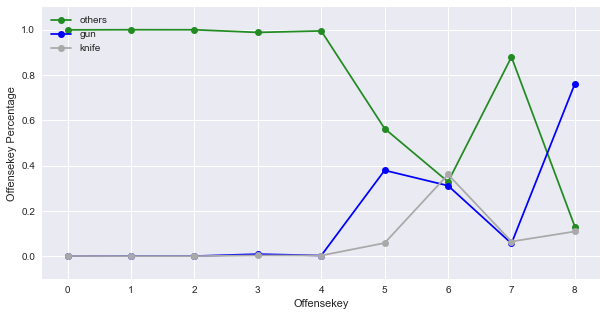

In [29]:
x = range(0,9)
y1 = offense_method["others"]
y2 = offense_method["gun"]
y3 = offense_method["knife"]

print(type(x))
print((y1))

plt.figure(figsize = (10,5))
plt.style.use('seaborn')

plt.plot(x,y1,marker = 'o',color = "forestgreen",label = 'others')
plt.plot(x,y2,marker = 'o',color = "blue",label = "gun")
plt.plot(x,y3,marker = 'o',color = "darkgrey",label = "knife")

plt.legend(labels = ["others","gun","knife"],loc = "upper left")

plt.ylim(-0.1,1.1)
plt.xlabel("Offensekey")
plt.ylabel("Offensekey Percentage")

0-4 on the horizontal axis belongs to property, and 5-8 belongs to violent. 

It is easy to see that in the property category, neither guns nor knives were used. The perpetrators may be barehanded, or they may use other weapons such as brass knuckles, batons, etc.

"5" stands for "robbery". As can be seen from the picture, robbery does not require too many knives (probably because knives are not as effective as guns), but it requires more equipment support than theft and arson.

"6" stands for “assault w/dangerous weapon”. It can be seen that the proportion of guns and knives has increased significantly, but the “other” type still exists.

"7" stands for "sex abuse". It can be seen that in cases related to sex abuse, the others category is far more than the other two categories, so banning guns may have little effect on preventing sex abuse. In order to prevent the continued occurrence of this crime, we should start from other aspects, such as improving the average education level.

"8" stands for "homicide". It can be seen that a large proportion of homicides involve the use of firearms. This category reflects the importance of gun control.

## 3.3 Correlation between "offensekey" and "PSA"

From the heat map, we can see that the correlation coefficient between offensekey and PSA is as high as 0.25, which means there may be a weak connection between the two. Using the same method as above, we can draw a line graph of offensekey and PSA.

In [30]:
cr_offense_PSA = cr[["offensekey","PSA"]]
cr_offense_PSA.corr()

,offensekey,PSA
offensekey,1.000000,0.249319
PSA,0.249319,1.000000


In [31]:
off_key0 = list()
off_key1 = list()
off_key2 = list()
off_key3 = list()
off_key4 = list()
off_key5 = list()
off_key6 = list()
off_key7 = list()
off_key8 = list()

temp_lists = [off_key0,off_key1,off_key2,off_key3,off_key4,off_key5,off_key6,
             off_key7,off_key8]

for i in range (0,9):
    temp_lists[i] = cr_offense_PSA[cr_offense_PSA["offensekey"] == i].PSA.value_counts().sort_index()

offense_PSA = pd.DataFrame(columns = (cr.offensekey.value_counts().sort_index().index))

index_PSA = cr.PSA.value_counts().sort_index().index

for alist in temp_lists:
    for ind in index_PSA:
        if ind not in alist.index:
            alist[i] = 0

for i in range (0,9):
    offense_PSA[i] = (temp_lists[i].sort_index()/cr["offensekey"].value_counts().sort_index()[i])
    
del temp_lists
offense_PSA['PSA'] = index_PSA
offense_PSA.fillna(0).head(10)

,0,1,2,3,4,5,6,7,8,PSA
101.0,0.033320,0.021046,0.011978,0.006212,0.002809,0.018264,0.013083,0.019904,0.004953,101.0
102.0,0.020315,0.013440,0.012168,0.005906,0.022472,0.014616,0.016128,0.020225,0.015410,102.0
103.0,0.009195,0.012383,0.007851,0.004457,0.005618,0.009736,0.006541,0.008026,0.002201,103.0
104.0,0.025445,0.024505,0.018098,0.024096,0.008427,0.021959,0.012114,0.014125,0.008806,104.0
105.0,0.011012,0.008009,0.009867,0.006741,0.011236,0.009381,0.015056,0.011557,0.015410,105.0
106.0,0.033491,0.025218,0.018051,0.019667,0.008427,0.018880,0.013498,0.014125,0.019263,106.0
107.0,0.022519,0.023288,0.017221,0.017160,0.005618,0.018358,0.011906,0.022151,0.001651,107.0
108.0,0.016335,0.018880,0.015276,0.015015,0.011236,0.012863,0.005468,0.005778,0.004403,108.0
201.0,0.006400,0.013432,0.007068,0.011672,0.000000,0.002321,0.001211,0.001926,0.001101,201.0
202.0,0.024142,0.018956,0.006404,0.016603,0.000000,0.006727,0.003426,0.005457,0.002201,202.0


Text(0, 0.5, 'Offensekey Percentage')

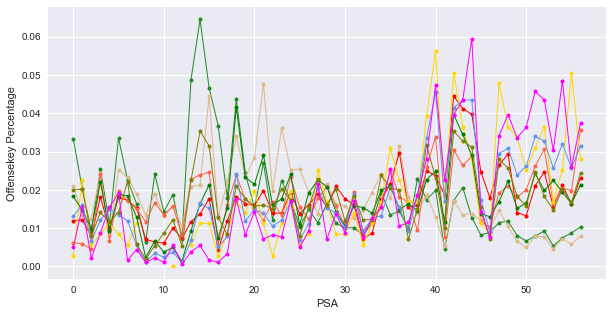

In [32]:
x = range(len(index_PSA))
y0 = offense_PSA[0]
y1 = offense_PSA[1]
y2 = offense_PSA[2]
y3 = offense_PSA[3]
y4 = offense_PSA[4]
y5 = offense_PSA[5]
y6 = offense_PSA[6]
y7 = offense_PSA[7]
y8 = offense_PSA[8]

plt.figure(figsize = (10,5))
plt.style.use('seaborn')

plt.plot(x,y0,marker = 'o',markersize = 4,linewidth = 1,
         color = "forestgreen",label = '0')
plt.plot(x,y1,marker = 'o',markersize = 4,linewidth = 1,
         color = "burlywood",label = '1')
plt.plot(x,y2,marker = 'o',markersize = 4,linewidth = 1,
         color = "red",label = "2")
plt.plot(x,y3,marker = 'o',markersize = 4,linewidth = 1,
         color = "tomato",label = "3")
plt.plot(x,y4,marker = 'o',markersize = 4,linewidth = 1,
         color = "gold",label = "4")
plt.plot(x,y5,marker = 'o',markersize = 4,linewidth = 1,
         color = "green",label = "5")
plt.plot(x,y6,marker = 'o',markersize = 4,linewidth = 1,
         color = "cornflowerblue",label = "6")
plt.plot(x,y7,marker = 'o',markersize = 4,linewidth = 1,
         color = "olive",label = "7")
plt.plot(x,y8,marker = 'o',markersize = 4,linewidth = 1,
         color = "magenta",label = "8")

# plt.legend(labels = ["0","1","2"],loc = "upper left")

# plt.ylim(-0.1,1.1)
plt.xlabel("PSA")
plt.ylabel("Offensekey Percentage")

We found that certain PSAs had particularly high theft rates, and certain PSAs had particularly high homicide rates. Based on these data, each PSA needs to take appropriate measures.

# 4. Correlation between crime and location

According to the given longitude and latitude, we plot the location where each case occurred on the graph, and we can get the following scatter plot:

E:\annaconda\lib\site-packages\seaborn\axisgrid.py:2036: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.
  warnings.warn(msg, UserWarning)


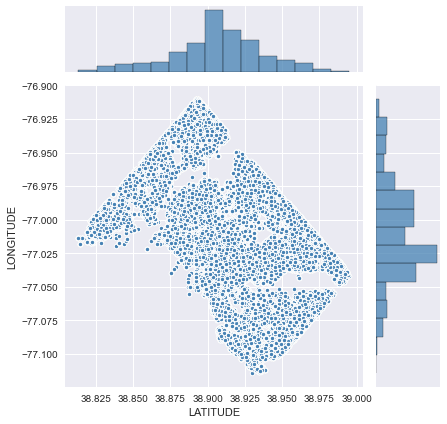

In [33]:
sns.jointplot(x=cr['LATITUDE'], y=cr['LONGITUDE'],
              data=cr,   
              color = 'steelblue',   
              s = 20, edgecolor="w",linewidth=1,  
              kind = 'scatter',   
              space = 0.2,
              height = 6,
              ratio = 4,
              marginal_kws=dict(bins=15, rug=True)
              )  

## 4.1 Correlation between crime and the streets

To get more specific, we'll look at which streets are more dangerous.

Through observation, it is not difficult to find that most of the blocks in the given cases are in the form of "XXXX-XXXX block of street name AB" or "XXXX XXXX block of street name AB", where "XXXX-XXXX" and "XXXX XXXX" represent 2 to 8 digit numbers, and AB represents specific directions, such as ne represents northeast, and sw represents southwest. Here, the "street name" text segment is extracted to form a new feature, representing the street where the case occurred.

In [34]:
street_name = list()
cr["STREET"] = ''

for i in range (0,len(cr)):
    block = str(cr.loc[i,"BLOCK"])
    temp = re.findall('(?<=block of ).*$', block)
    st_direction = ''.join(temp)
    st_name = st_direction[:-3]
    street_name.append(st_name)

cr["STREET"] = street_name
st_times = cr.STREET.value_counts()
print(st_times)
cr.head()

                      22359
14th street           12533
georgia avenue         9617
connecticut avenue     8331
m street               8137
                      ...  
langley way               1
dunbar road               1
hillandale drive          1
congress court            1
jackson place             1
Name: STREET, Length: 1281, dtype: int64


,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,SHIFT,YBLOCK,DISTRICT,WARD,YEAR,...,OCTO_RECORD_ID,ANC,REPORT_DAT,METHOD,LATITUDE,DAY_OF_WEEK,SEASON,TIME,DURATION,STREET
0,21,8702.0,0,-77.003574,2017-04-29T08:00:23.000,0,138139.0,5.0,5.0,2017,...,17070672-01,5E,2017-04-29T13:49:31.000Z,0,38.911114,6,0,1,7.50,q street
1,16,1600.0,0,-77.026557,2017-04-29T08:30:37.000,0,146051.0,4.0,4.0,2017,...,17070675-01,4A,2017-04-29T14:38:59.000Z,0,38.982384,6,0,2,7.00,georgia avenue
2,8,4702.0,0,-77.020913,2017-04-29T11:10:57.000,0,137185.0,1.0,6.0,2017,...,17070714-01,6E,2017-04-29T15:19:02.000Z,0,38.902518,6,0,10,1.45,k street
3,31,7808.0,0,-76.919601,2017-04-28T09:30:33.000,0,135903.0,6.0,7.0,2017,...,17070736-01,7C,2017-04-29T16:11:44.000Z,0,38.890943,5,0,9,1.25,blaine street
4,39,10900.0,0,-77.003927,2017-04-29T13:42:11.000,0,128340.0,7.0,8.0,2017,...,17070780-01,8D,2017-04-29T18:17:15.000Z,0,38.822840,6,0,13,1.65,south capitol str


It can be seen that there are 22356 cases where the blocks are not represented in this way. It is observed that some of them are presented in the form of "street a AB and street b AB", and some are "intersta XXXXX", representing interstate highways.

In [35]:
n = 0
for i in range (0,len(cr)):
    block = str(cr.loc[i,"BLOCK"])
    if 'interstate' in block:
        n = n+1
print("number of cases happened around interstate: ",n)
print(n/len(cr))

number of cases happened around interstate:  68
0.00015137922053058418


As can be seen, interstate highways only account for 0.015% of all cases, so they can be discarded. Next, count the streets that have been included and reappeared in "street a AB and street b AB" and the number of times.

In [36]:
not_include = st_times['']
for i in range (0,len(cr)):
    block = str(cr.loc[i,"BLOCK"])
    if ' and ' in block:
        not_include -= 1
        st_1 = block[0:block.rfind(' and ')]
        st_1 = st_1[:-3]
        st_2 = block[block.rfind(' and ')]
        st_2 = st_2[:-3]
        if st_1 in st_times:
            st_times[st_1] = st_times[st_1]+1
        if st_2 in st_times:
            st_times[st_2] = st_times[st_2]+1
            
st_times[''] = not_include

In this way, the number of uncounted cases is much smaller than the total data volume.

Next, rearrange them in order of number of cases. 

In [37]:
st_times.sort_values(ascending = False)

14th street           13249
georgia avenue        10016
connecticut avenue     8456
m street               8420
7th street             7272
                      ...  
kingman alley             1
lincoln circle            1
norton street             1
battery place             1
w waverly terrace         1
Name: STREET, Length: 1281, dtype: int64

Compute the covariance matrix of the two.

In [38]:
np.cov(st_times,cr["STREET"].value_counts())

array([[1023483.2882038 ,  966257.05928474],
       [ 966257.05928474, 1299142.26484314]])

It was found that the two are very similar. This may be because the two variables are both assigned by location.

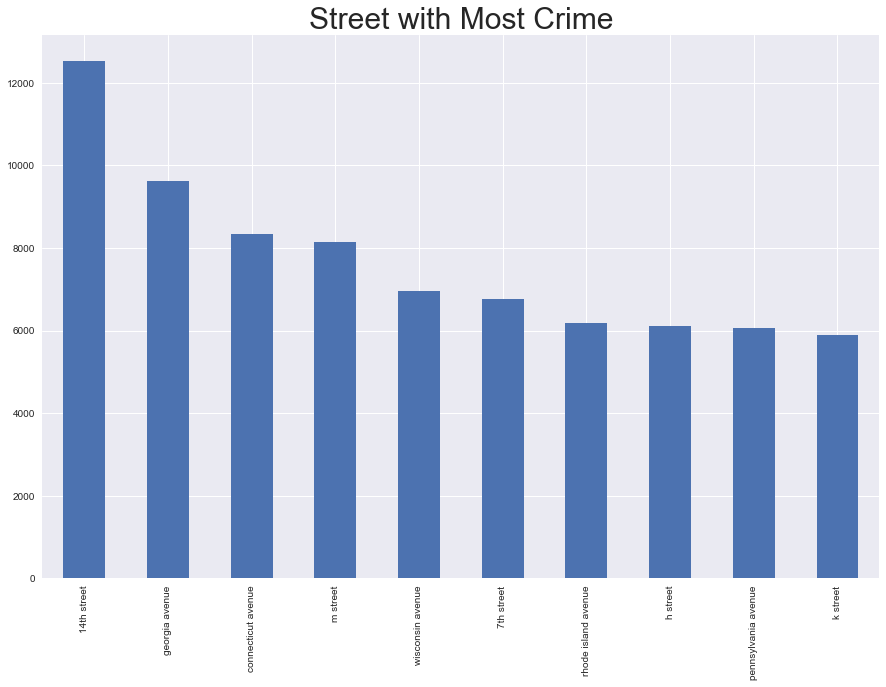

In [39]:
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('seaborn')

cr['STREET'].value_counts().iloc[1:11].plot.bar( figsize = (15, 10))

plt.title('Street with Most Crime',fontsize = 30)

plt.show()

From the graph, we can see that 14th Street has the most crimes. This could be because of the large population, poor management, or because this street is in the PSA with a high number of crimes.

## 3.2 Correlation between Crime and NEIGHBORHOOD_CLUSTER

In [40]:
cr.NEIGHBORHOOD_CLUSTER.value_counts().sort_index()

0      5502
1     11193
2     35723
3     19265
4     12990
5      7227
6     25020
7     15415
8     30045
9      7686
10     3714
11     7737
12     2791
13     2977
14     3758
15     5119
16     2580
17    12374
18    20579
19     6243
20     5334
21    16221
22    14869
23    17156
24     6056
25    25393
26    20583
27     3010
28     5266
29     1294
30     6396
31    12342
32    10907
33    12205
34    11078
35     4522
36     4583
37     6076
38     8425
39    19450
40        7
41        2
43       23
44       17
45       41
46        9
Name: NEIGHBORHOOD_CLUSTER, dtype: int64

<BarContainer object of 46 artists>

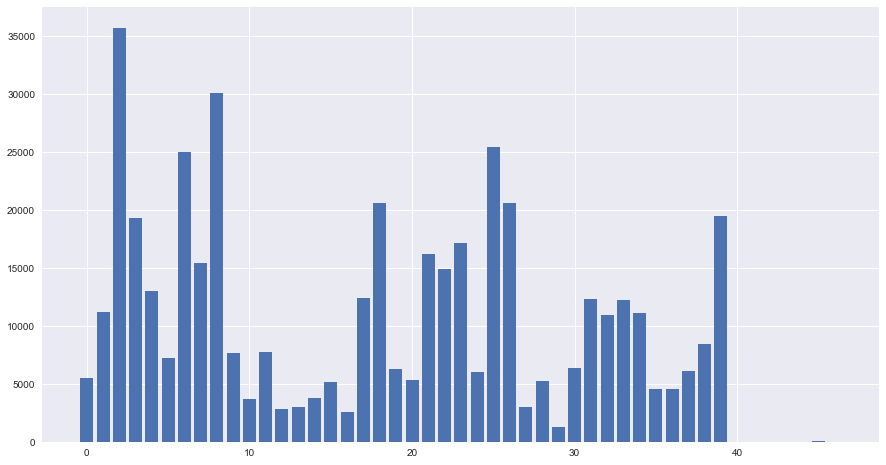

In [41]:
x = cr.NEIGHBORHOOD_CLUSTER.value_counts().sort_index().index
y = cr.NEIGHBORHOOD_CLUSTER.value_counts().sort_index()
plt.figure(figsize = (15,8))
plt.bar(x,y)

From the figure, we can see that the area after CLUSTER_NEIGHBORHOOD 40 is very peaceful. Take out CLUSTER 2 with the most crimes and study the time of its crimes.

In [42]:
list1 = ["day","night","midnight","season"]
cr_clu2_season_shift = pd.DataFrame(columns = list1)
cr_clu2_season_shift["season"] = ["spring","summer","autumn","winter"]

season_day = list()
season_night = list()
season_midnight = list()
temp_lists = [season_day,season_night,season_midnight]

for i in range (0,3):
    temp_lists[i] = cr[cr["SHIFT"] == i].SEASON.value_counts().sort_index()
    cr_clu2_season_shift[list1[i]] = temp_lists[i]

print(cr_clu2_season_shift)

     day  night  midnight  season
0  37149  43077     19105  spring
1  42855  47064     23256  summer
2  41985  48504     20548  autumn
3  37579  43898     17374  winter


([<matplotlib.patches.Wedge at 0x1689f7c83d0>,
 [Text(0.8066497721024221, 0.7478744180456439, 'Spring'),
  Text(-0.8150268026716715, 0.738736293224309, 'Summer'),
  Text(-0.6147529113124576, -0.9121835659738986, 'Autumn'),
  Text(0.855419678132269, -0.6915614031046595, 'Winter')],
 [Text(0.43999078478313924, 0.4079315007521694, '23.8%'),
  Text(-0.444560074184548, 0.40294706903144123, '29.0%'),
  Text(-0.335319769806795, -0.4975546723493992, '25.6%'),
  Text(0.46659255170851033, -0.3772153107843597, '21.6%')])

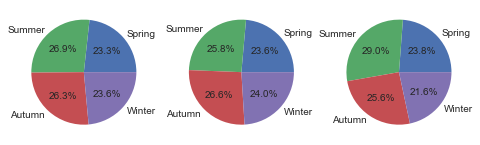

In [43]:
labels = ['Spring','Summer','Autumn','Winter']
fig, axs = plt.subplots(1,3)
axs[0].pie(cr_clu2_season_shift["day"], labels = labels, autopct = '%1.1f%%')
axs[1].pie(cr_clu2_season_shift["night"], labels = labels, autopct = '%1.1f%%')
axs[2].pie(cr_clu2_season_shift["midnight"], labels = labels, autopct = '%1.1f%%')

From left to right are the distribution maps of day shift, night shift, and midnight shift. We can tell that the crimes are almost evenly divided into four seasons. However, in summer, the number of crimes during the midnight shift increases significantly, while it decreases in winter. Therefore, the police should pay extra attention to the midnight in summer.

# 4 kNN classification based on geographic location

## 4.1 Data standardization

In [44]:
cr_location = cr[['CENSUS_TRACT','PSA','DISTRICT',
                 'XBLOCK','YBLOCK','LONGITUDE','LATITUDE','NEIGHBORHOOD_CLUSTER']]
cr_location_minmax = pd.DataFrame()

for col in cr_location.columns[0:9]:
    cr_location = cr_location[cr_location[col].notnull()]
# cr_location.dropna(axis = 0, how = 'any')

def min_max_normalize(x):
    return (x - x.min())/(x.max() - x.min())

for col in cr_location.columns[0:7]:
    cr_location_minmax[col] = min_max_normalize(cr_location[col])
    
print(cr_location.shape)
cr_location_minmax.head(10)

(447768, 8)


,CENSUS_TRACT,PSA,DISTRICT,XBLOCK,YBLOCK,LONGITUDE,LATITUDE
0,0.782000,0.660626,0.666667,0.541547,0.538156,0.541677,0.538184
1,0.136364,0.494234,0.500000,0.429080,0.930987,0.429084,0.931009
2,0.418364,0.000000,0.000000,0.456589,0.490790,0.456735,0.490806
3,0.700727,0.835255,0.833333,0.953059,0.427139,0.953065,0.427010
4,0.981818,1.000000,1.000000,0.539796,0.051636,0.539950,0.051643
5,0.436545,0.339374,0.333333,0.436593,0.508018,0.436736,0.508031
6,0.009273,0.172982,0.166667,0.211264,0.519388,0.211421,0.519297
7,0.145636,0.494234,0.500000,0.470768,0.865995,0.470827,0.866025
8,0.082000,0.166392,0.166667,0.180760,0.717094,0.180730,0.716988
9,0.645455,0.008237,0.000000,0.534429,0.347252,0.534572,0.347272


## 4.2 Dividing the test set and training set

Here, we use 95% to train the model and 5% to test the model (due to insufficient computer memory). Since we only need to cluster using geographic location, we delete other information that is not related to geographic location and information that is inconvenient to process and standardize it by min-max to delete missing values.

In [45]:
y = cr_location['NEIGHBORHOOD_CLUSTER']
del cr_location['NEIGHBORHOOD_CLUSTER']
X = cr_location_minmax
cr_train, cr_test,\
cr_train_labels, cr_test_labels \
= model_selection.train_test_split(X, y, test_size=0.05, random_state=0)

## 4.3 Model training

The NEIGHBORHOOD_CLUSTER in the data is divided into 47 categories in total. Here we take k = 20.

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 20)
knn_model.fit(cr_train, cr_train_labels)

KNeighborsClassifier(n_neighbors=20)

In [47]:
cr_test_pred = knn_model.predict(cr_test)

## 4.4 Model performance evaluation

In [48]:
from sklearn import metrics
print (metrics.classification_report(cr_test_labels, cr_test_pred))
print (metrics.confusion_matrix(cr_test_labels, cr_test_pred))
print (metrics.accuracy_score(cr_test_labels, cr_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       283
           1       0.99      1.00      1.00       544
           2       0.99      1.00      1.00      1768
           3       0.99      0.99      0.99       953
           4       1.00      1.00      1.00       612
           5       0.99      0.99      0.99       370
           6       0.99      0.99      0.99      1298
           7       0.99      0.98      0.99       774
           8       0.99      1.00      0.99      1495
           9       1.00      1.00      1.00       409
          10       0.99      0.99      0.99       182
          11       0.99      1.00      1.00       367
          12       1.00      1.00      1.00       143
          13       0.98      1.00      0.99       150
          14       0.99      0.98      0.99       200
          15       1.00      1.00      1.00       249
          16       0.99      1.00      1.00       140
          17       0.99    

E:\annaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The overall correct prediction rate of the model is about 99.35%. This is a good result for community segmentation. 

## 4.5 Model performance improvement

Here we take different values ​​of k to improve the performance of the model. We will test the results when k = 1, 5, 10, 50. Since there are many types of output labels, we will only judge the performance of the model by accuracy. 

In [49]:
k_list = (1, 5, 10, 50)
for k in k_list:
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(cr_train, cr_train_labels)

    cr_test_pred = knn_model.predict(cr_test)
    accuracy = metrics.accuracy_score(cr_test_labels, cr_test_pred)
    
    print ("k = ",k)
    print ("\t accuracy: ", '%.2f'%(accuracy*100) + "%")

k =  1
	accuracy:  99.62%
k =  5
	accuracy:  99.63%
k =  10
	accuracy:  99.52%
k =  50
	accuracy:  98.87%


The most accurate result is when k = 5. This is much smaller than we have expected. 

# 5 Housing price prediction

## 5.1 Outlier handling

First, encode the data and extract the street on which each house is located.

In [50]:
pr = pd.read_csv('DC_Properties.csv')

E:\annaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [51]:
pr['STREET'] = ''
pr_street_name = list()

for i in range (0,len(pr)):
    address = str(pr.loc[i,"FULLADDRESS"])
    if (address[0]).isdigit():
        a = address.split()
        a.pop(0)
        a.pop(-1)
        b = ' '.join(a)
        pr_street_name.append(b)
    else:
        pr_street_name.append(-1)

pr["STREET"] = pr_street_name

In [52]:
# index_HEAT = pr.HEAT.value_counts().index
to_be_done = ["HEAT","AC","QUALIFIED","STYLE","STRUCT","GRADE","CNDTN","EXTWALL","ROOF",
             "INTWALL","SOURCE","CITY","STATE","ASSESSMENT_NBHD","ASSESSMENT_SUBNBHD",
             "WARD","QUADRANT","STREET"]
coding = [list() for i in range(len(to_be_done))]
temp_index = list()

def preprocess(x):
    temp_index = pr[x].value_counts().index.copy()
    for i in range (len(temp_index)):
        pr.loc[pr[x]==temp_index[i],x] = i

for i in range (len(to_be_done)):
    preprocess(to_be_done[i])
    
pr[pr['SQUARE']=='PAR '] = 0
pr = pr[pr["PRICE"].notnull()]
pr = pr[pr["PRICE"]!=0]

pr_prototype = pr.copy()

pr.head(5)

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,STREET
0,0,4,0,2,0,2.0,8,4,1910.0,1988.0,...,0,0,4201.0,004201 2006,3,152,-77.040429,38.914881,0,187
2,2,3,1,1,0,2.0,9,5,1910.0,2009.0,...,0,0,4201.0,004201 2006,3,152,-77.040429,38.914881,0,187
3,3,3,1,1,0,2.0,8,5,1900.0,2003.0,...,0,0,4201.0,004201 2006,3,152,-77.040429,38.914881,0,187
5,5,3,2,1,0,1.0,10,5,1913.0,NaN,...,0,0,4201.0,004201 2006,3,152,-77.040429,38.914881,0,13
7,7,3,1,1,0,2.0,8,4,1906.0,2011.0,...,0,0,4201.0,004201 2005,3,152,-77.040429,38.914881,0,921


Check if there are any outliers in the housing prices.

count    9.811500e+04
mean     9.318429e+05
std      7.064937e+06
min      1.000000e+00
25%      2.400000e+05
50%      3.999990e+05
75%      6.520000e+05
max      1.374275e+08
Name: PRICE, dtype: float64


E:\annaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PRICE'>

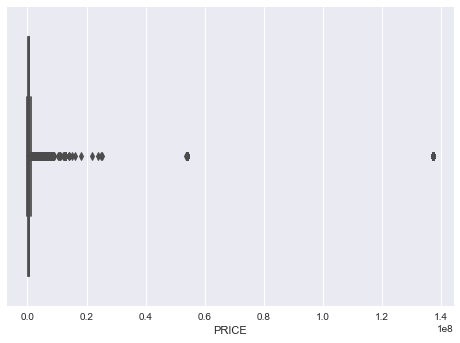

In [53]:
prices = pr.PRICE
print(prices.describe())
sns.boxplot(prices)

We can easily find that the maximum and standard deviation are both outrageously large; the maximum is even three orders of magnitude larger than the quartile. There are two obvious outliers in the graph, and because of them, we can't even see the boxes of the box plot. This will seriously affect our results. We use the base 10 logarithm instead.

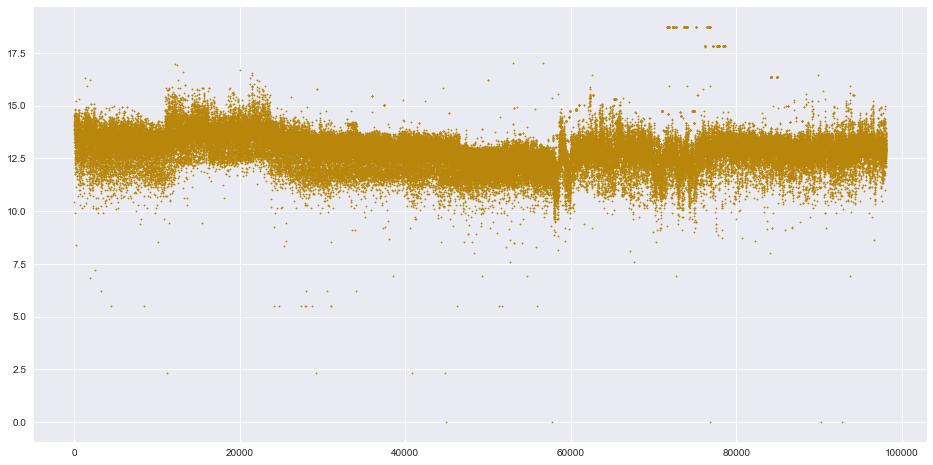

In [54]:
pr_noln = pr.copy()
prices = pr["PRICE"]
import math

prices = prices.values.tolist()
prices = np.log(prices)
    
x = range(len(prices))
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x,prices,color = 'darkgoldenrod',s = 2)
plt.show();

In [55]:
pr["PRICE"] = prices
pr["PRICE"].describe()

count    98115.000000
mean        12.871037
std          0.892980
min          0.000000
25%         12.388394
50%         12.899217
75%         13.387800
max         18.738607
Name: PRICE, dtype: float64

Now this looks much better. 

## 5.2 Feature selection

Normalize some data min-max, then select the data to draw a heat map.

In [56]:
pr_hot_map = pr
del pr_hot_map['Unnamed: 0']
del pr_hot_map['SALEDATE']
del pr_hot_map['GIS_LAST_MOD_DTTM']
del pr_hot_map['FULLADDRESS']
del pr_hot_map['NATIONALGRID']
del pr_hot_map['CENSUS_BLOCK']
del pr_hot_map['X']
del pr_hot_map['Y']
del pr_hot_map['ZIPCODE']

# del pr_hot_map['']
# pr.drop(["SALEDATE","GIS_LAST_MOD_DTTM","FULLADDRESS","NATIONALGRID"])

In [57]:
# for col in cr_location.columns[0:7]:
tb_minmax = ['PRICE','LONGITUDE','LATITUDE','AYB','EYB','GBA','LANDAREA','CENSUS_TRACT']

for i in tb_minmax:
    pr_hot_map[i] = min_max_normalize(pr_hot_map[i])
    pr_noln[i] = pr_noln[i]
# pr_hot_map['PRICE'] = min_max_normalize(pr_hot_map['PRICE'])
# pr_hot_map['LONGITUDE'] = min_max_normalize(pr_hot_map['LONGITUDE'])
# pr_hot_map['LATITUDE'] = min_max_normalize(pr_hot_map['LATITUDE'])
# pr_hot_map['PRICE'] = min_max_normalize(pr_hot_map['PRICE'])
pr_hot_map.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,...,STATE,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,WARD,SQUARE,QUADRANT,STREET
0,4,0,2,0,2.0,8,4,0.590909,1988.0,0.788991,...,0,0.540392,0.357955,0,0,0.372818,3,152,0,187
2,3,1,1,0,2.0,9,5,0.590909,2009.0,0.844037,...,0,0.540410,0.358710,0,0,0.372818,3,152,0,187
3,3,1,1,0,2.0,8,5,0.553030,2003.0,0.844037,...,0,0.540405,0.358949,0,0,0.372818,3,152,0,187
5,3,2,1,0,1.0,10,5,0.602273,NaN,0.788991,...,0,0.538405,0.363428,0,0,0.372818,3,152,0,13
7,3,1,1,0,2.0,8,4,0.575758,2011.0,0.788991,...,0,0.544532,0.361400,0,0,0.372818,3,152,0,921


## 5.3 Correlation investigation

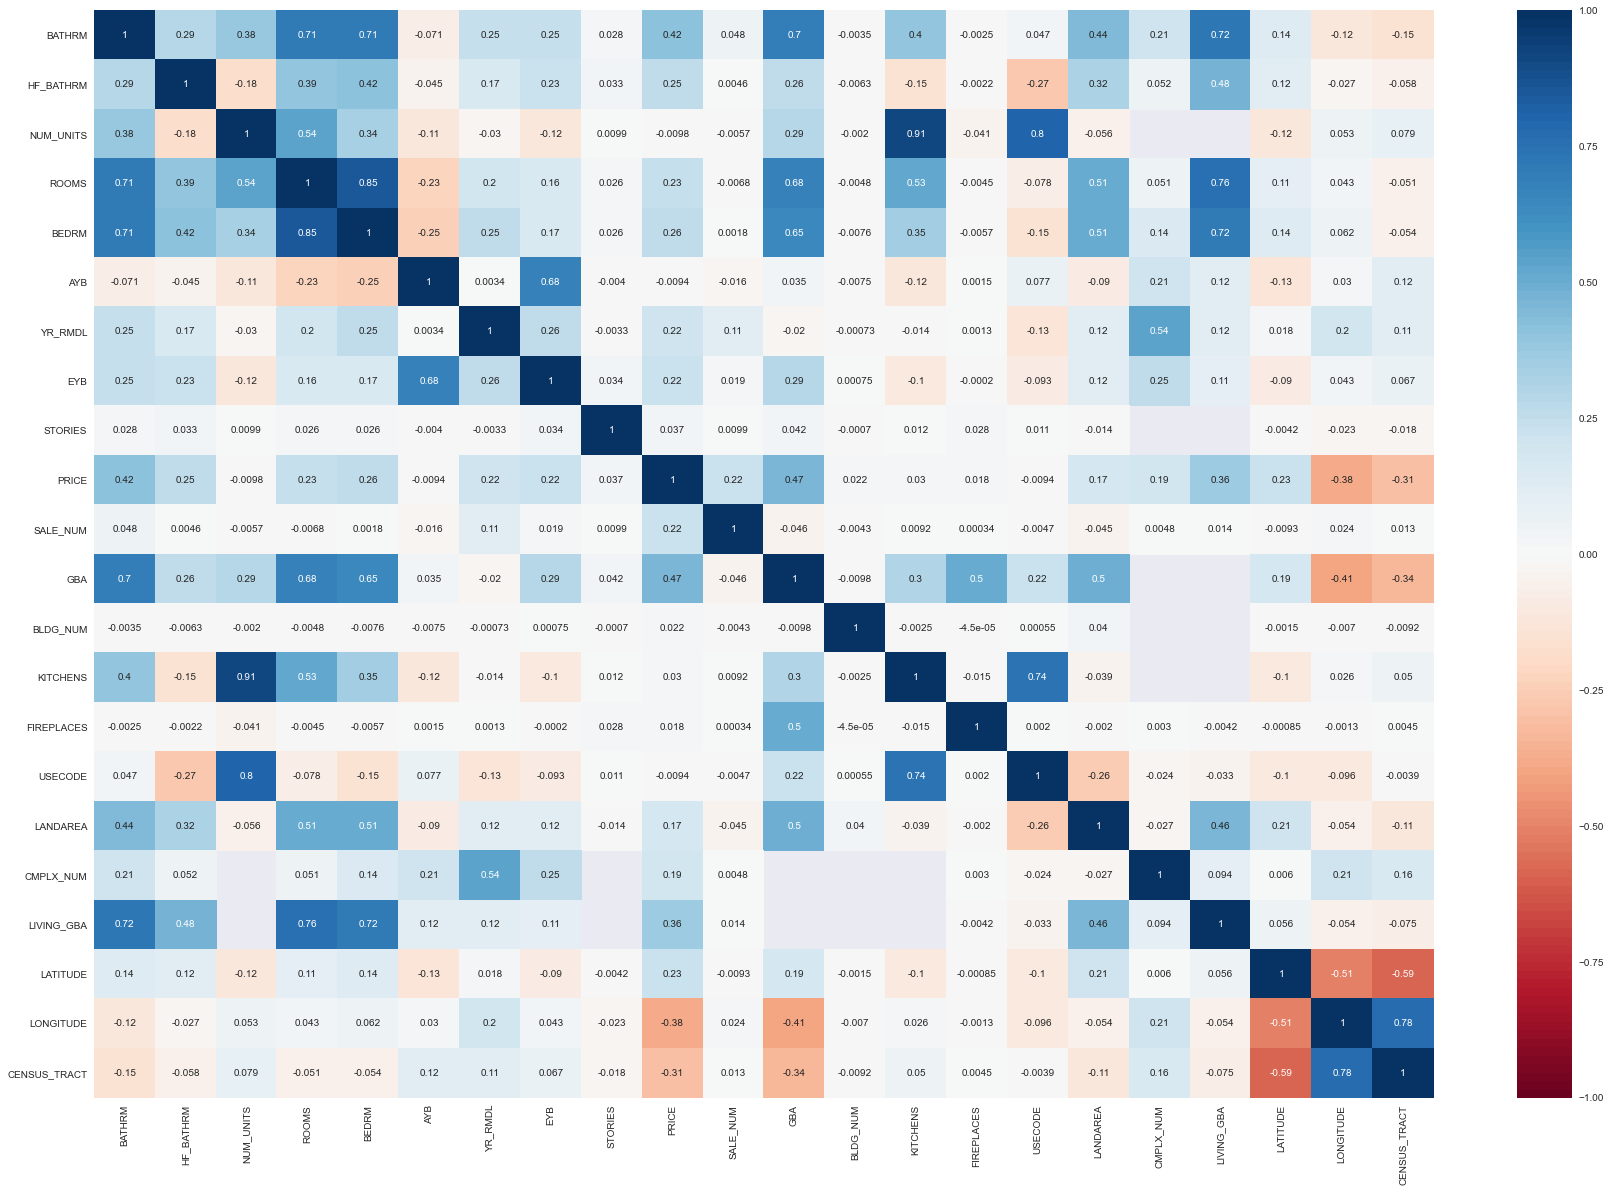

In [58]:
# pr_hot_map.fillna(value = -1,inplace = True)
# pr_hot_map.isnull().sum()
# np.float64(pr_hot_map)
sns.set_context(font_scale=1.5)
# pr_hot_map=pr_hot_map.dropna(how='any',axis=0)
plt.figure(figsize = (30,20))
sns.heatmap(pr_hot_map.corr(),vmin=-1,vmax=1,annot = True,cmap=sns.color_palette('RdBu',n_colors=128))
plt.savefig("properties_hot_map.jpg")
plt.show()

From the enlarged picture, we can find that the housing price is mainly related to GBA, i.e. the gross building area (square feet), and is also related to BATHRM and LONGITUDE.

Select four columns of features to construct a matrix scatter plot.

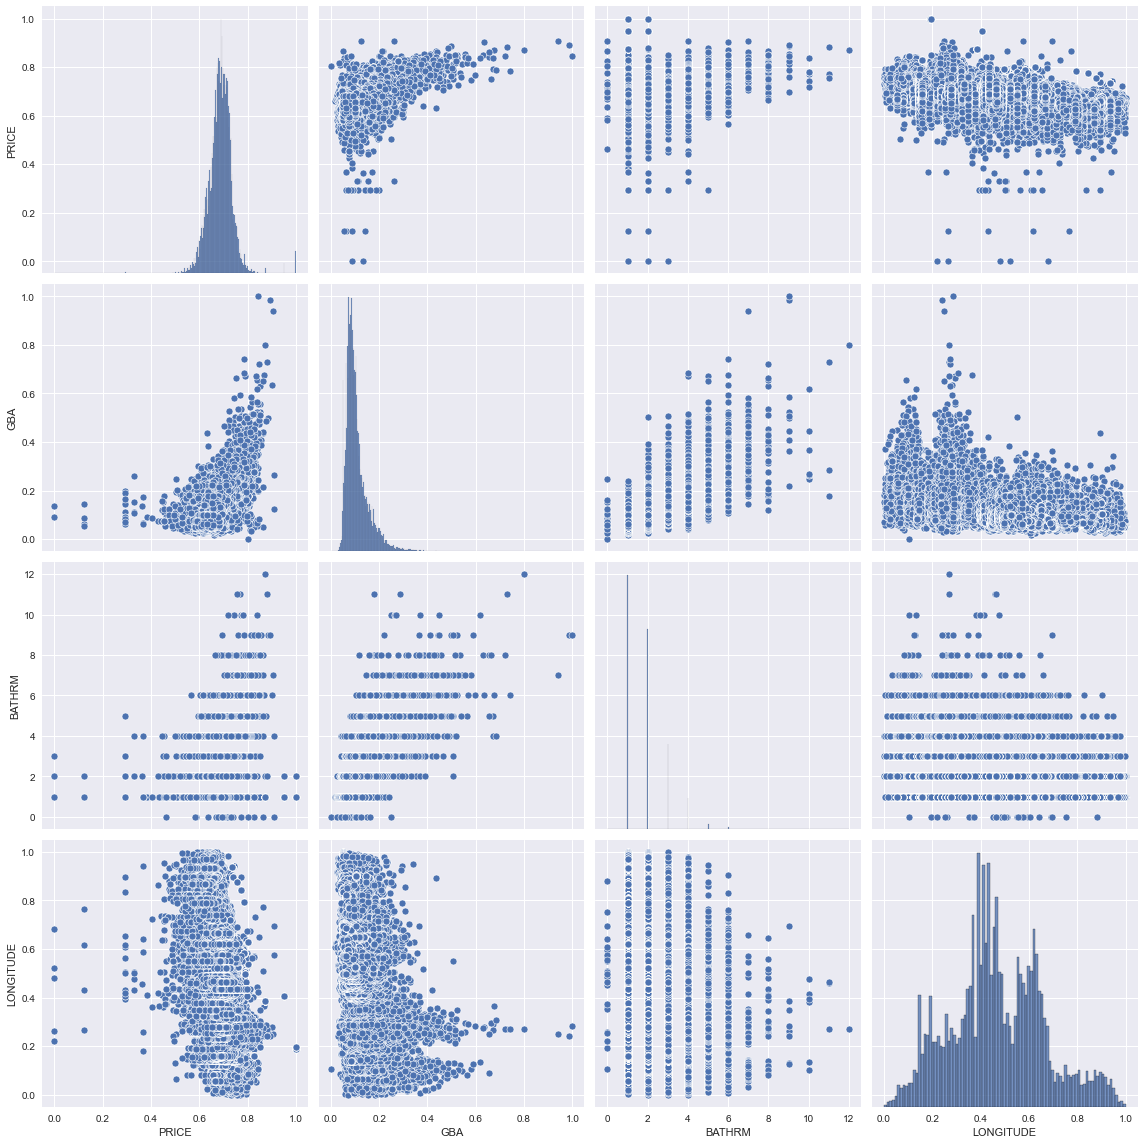

In [59]:
cols = ['PRICE','GBA','BATHRM','LONGITUDE']
sns.pairplot(pr_hot_map[cols], height=4)
plt.tight_layout()
plt.show()

As can be seen from the figure above, the logarithmic PRICE is mainly positively correlated with GBA (gross floor area) and BATHRM (number of bathrooms) as a whole, basically showing the shape of a logarithmic function and is basically unrelated to other dimensions. We can use linear regression to predict housing prices.

We can assume that if x represents GBA and y represents PRICE, then the two will have

$$ln(y) = \frac{ln(x)}{ln(a)}$$

namely: 

$$y = a·x$$

Turns out, all that logarithmic transformation was unnecessary.  A simple linear regression would have sufficed.

## 5.4 Model training

Since calling the LinearRegression function directly will exceed the memory, we can only calculate it manually.

In [60]:
from sklearn.linear_model import LinearRegression

pr = pr_noln[pr_noln['GBA']!=0]
pr = pr[pr['GBA'].notnull()]
pr = pr[pr['PRICE']!=0]
pr = pr[pr['PRICE'].notnull()]

X = pr[['GBA']].values
y = pr['PRICE'].values

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [61]:
LinearRegression(copy_X = True, fit_intercept = True, n_jobs = None,
                normalize = False)

LinearRegression()

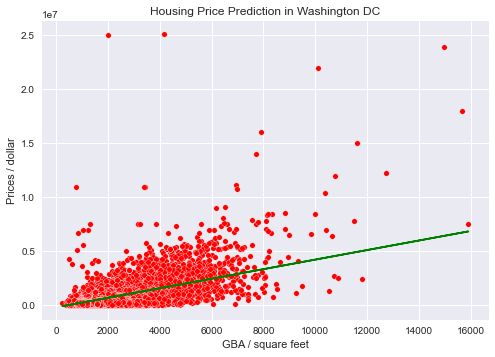

Slope = 442.35429170809294


In [62]:
plt.scatter(X, y, c='r', s=30, edgecolor='white',label='Train Data')
plt.plot(X.reshape(-1,1), lr.predict(X.reshape(-1,1)), c='g')
plt.xlabel('GBA / square feet')
plt.ylabel('Prices / dollar')
plt.title('Housing Price Prediction in Washington DC')
plt.show()
print('Slope = {}'.format(lr.coef_[0]))

Therefore, house price (/10^7) and floor space (square feet) basically present a linear regression relationship with a slope of 442.35429170809294.